# Identication of putative contaminant taxa

In [1]:
setwd("/mnt/c/git_repos/blood_microbial_signatures")
require(foreach)
require(tidyverse)
require(ggplot2)
require(data.table)
require(compositions)
require(doParallel)
require(VennDiagram)
# registerDoParallel(cores=16)

Loading required package: foreach

Warning message:
“package ‘foreach’ was built under R version 4.1.3”
Loading required package: tidyverse

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built u

### Data pre-processing functions

In [2]:
load_data <- function(file_path) {
    dat <- as.data.frame(fread(file_path)) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(dat)
}


load_metadata <- function(file_path, dat) {
    meta <- fread(file_path, na.strings=c("", NA))
    meta <- meta %>% 
        filter(npm_research_id %in% dat$npm_research_id) %>%
        select(-removal_requested_by_supplier) %>%
        replace(is.na(.), "unknown")
    return(meta)
}


subset_metadata <- function(meta, n_subset) {
    meta <- as.data.frame(meta)
    cohorts <- unique(meta$site_supplying_sample)
    subset_vec <- c()

    for (i in cohorts) {
        ids <- meta$npm_research_id[meta$site_supplying_sample == i]
        
        if (length(ids) > n_subset) {
            subset_ids <- sample(ids, n_subset)
            subset_vec <- c(subset_vec, subset_ids)
        } else {
            subset_vec <- c(subset_vec, ids)
        }
    }

    meta_sub <- meta %>%
      filter(npm_research_id %in% subset_vec) 
    return(meta_sub)
}


retrieve_rows_from_meta <- function(dat, meta) {
    return(dat %>% filter(npm_research_id %in% meta$npm_research_id)) 
}


remove_cols <- function(dat, col_to_exclude) {
    return(dat %>% select(-all_of(col_to_exclude)))
}


remove_low_prev_taxa <- function(dat, frac_presence, read_threshold) {
    n_original <- ncol(dat[, colnames(dat) != "npm_research_id"])
    PA_df <- apply(dat[, 2:ncol(dat)], 2, function(x) {ifelse(x > read_threshold, T, F)})
    frac_df <- apply(PA_df, 2, function(x) {sum(x) / nrow(PA_df)})
    to_keep <- names(frac_df[frac_df > frac_presence])
    to_keep <- c("npm_research_id", to_keep)
    n_new <- length(to_keep) - 1
    print(str_glue("{n_new} / {n_original} taxa are present in {frac_presence} of samples"))
    return(dat %>% select(all_of(to_keep)))
}


otu_to_RA <- function(dat) {
    mat <- as.matrix(dat[, colnames(dat) != "npm_research_id"])
    RA_df <- as.data.frame(mat / rowSums(mat))
    RA_df <- add_column(RA_df, dat$npm_research_id, .before = 1)
    colnames(RA_df)[1] <- "npm_research_id"
    
    return(RA_df)
}


RA_to_clr <- function(dat) {
    mat <- dat[, colnames(dat) != "npm_research_id"]
    clr_df <- clr(mat)
    return(cbind(data.frame(npm_research_id = dat$npm_research_id), as.data.frame(clr_df, check.names = F)))
}


get_metadata_plots <- function(meta, meta_cols) {
    meta <- as.matrix(meta)
    meta <- as_tibble(meta, rownames = "sample")

    plots <- list()
    
    for (column in meta_cols) {
        plt <- meta %>%
            mutate(across(everything(), as.character)) %>%
            select(all_of(column)) %>%
            group_by_at(column) %>%
            summarise(n = n()) %>%
            ggplot(aes_string(x = column, y = "n", fill = column)) +
                geom_bar(stat = "identity") +
                theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                geom_text(aes_string(label = "n"))
        plots[[column]] <- plt
    }
    
    return(plots)
}


get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


print_group_freqs <- function(meta, meta_cols) {
    for (col in meta_cols) {
        tmp <- tibble(data.frame(meta)) %>%
            group_by(get(col)) %>%
            summarise(n = n())
        print(col)
        print(tmp)
    }
}


get_batch_prevalence <- function(x) {sum(x) / length(x)}


remove_low_sample_levels <- function(dat, metadat, column, min_samples) {
    # Remove levels with < x samples
    tmp <- tibble(data.frame(metadat)) %>%
            group_by(get(column)) %>%
            summarise(n = n())

    # Vector of group levels to keep
    to_keep <- tmp[tmp$n >= min_samples, "get(column)"]$`get(column)`
    to_keep <- to_keep[to_keep != "Unknown"]
    n_levels <- length(to_keep)

    if (n_levels < 2) {
        print(str_glue("After pruning, {column} has < 2 levels"))
    } else {
        print(str_glue("After pruning, {column} has {n_levels} levels"))
    }

    # Remove rows in metadata
    metadat_filt <- metadat %>% filter(get(column) %in% to_keep)

    # Retrieve rows
    dat_filt <- retrieve_rows_from_meta(dat, metadat_filt)
    metadat_filt <- metadat_filt %>% filter(npm_research_id %in% dat_filt$npm_research_id)

    return(list(dat_filt = dat_filt, metadat_filt = metadat_filt))
}


remove_empty_rows <- function(dat) {
    mat <- as.matrix(dat[, colnames(dat) != "npm_research_id"])
    row_sums <- rowSums(mat)
    df_filt <- dat[row_sums != 0, ]
    nrow(df_filt)

    n_original <- nrow(dat)
    n_removed <- n_original - nrow(df_filt)
    
    print(str_glue("{n_removed}/{n_original} samples removed due to having no reads of interest"))
    
    return(df_filt)
}


load_metadata <- function(file_path, dat) {
    meta <- fread(file_path, na.strings=c("", NA))
    meta <- meta %>% 
        filter(npm_research_id %in% dat$npm_research_id) %>%
        select(-removal_requested_by_supplier) %>%
        replace(is.na(.), "unknown")
    return(meta)
}

#### Params

In [3]:
human <- "Homo sapiens"
rank <- "S"
max_prev_t <- 0.25
fold_diff_t <- 2

#### Load and parse data

In [4]:
to_retain <- fread("data/samples_above_100_microbial_reads.txt")$npm_research_id

prev_df <- fread("results/decontamination/prevalence_RA0.005_read10.csv")

species_df <- load_data(str_glue("data/taxonomic_profiles/07_abundance_matrix/abundance_matrix.S.pipeline2_210322.tsv")) %>% 
    filter(npm_research_id %in% to_retain) %>%
    select(all_of(colnames(prev_df)))

all(colnames(species_df) == colnames(prev_df))

meta_filt <- load_metadata("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv", species_df)

# Convert to CLR abundances
df_filt <- RA_to_clr(otu_to_RA(species_df))
dim(species_df)

[1] TRUE

[1] 8892  871

### Correlation filter within batches

In [5]:
corr_decontam <- function(dat, non_contaminants, contaminants, meta_col, level) {
    nc_list <- foreach (non_contaminant_taxon = non_contaminants) %do% {
        morsel <- tibble()
        
        for (contaminant_taxon in contaminants) {
            spearman_test <- cor.test(dat[ , contaminant_taxon], dat[, non_contaminant_taxon])
            rho <- spearman_test$estimate
            print(str_glue("Computing correlations for {meta_col}: {level}"))
            morsel <- morsel %>% bind_rows(tibble(meta_col = meta_col, 
                                                  level = level,
                                                  non_contaminant_taxon = non_contaminant_taxon, 
                                                  contaminant_taxon = contaminant_taxon,
                                                  rho = rho))
        }

        return(morsel)
    }

    corr_df <- bind_rows(nc_list)  
    return(corr_df)
}


In [6]:
# Get non-contaminants/contaminants from diff prev. filter
diff_prev_contams_nc <- read.csv(str_glue("results/decontamination/diff_prev_V3/noncontaminants.RA0.005.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.txt"))$taxa
diff_prev_contams <- read.csv(str_glue("results/decontamination/diff_prev_V3/contaminants.RA0.005.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.txt"))$taxa

diff_prev <- fread("results/decontamination/diff_prev_V3/decon_V3_raw.RA0.005.read_threshold10.csv") %>%
    as_tibble()

diff_filt <- diff_prev %>%
    filter(fold_diff > 2, max_prev > 0.25)

iter_list <- diff_filt %>% 
    distinct(meta_col, max_level)

In [7]:
# morsels <- foreach(i = seq(nrow(iter_list))) %dopar% {
#     var_name <- iter_list[i, ]$meta_col
#     level_name <- iter_list[i, ]$max_level

#     contams <- (diff_filt %>% filter(meta_col == var_name, max_level == level_name))$taxa

#     noncontams <- colnames(df_filt)
#     noncontams <- noncontams[!(noncontams %in% c("npm_research_id", contams))]

#     batch_dat <- df_filt %>%
#         left_join(meta_filt %>% select(all_of(c("npm_research_id", var_name)))) %>%
#         filter(get(var_name) == level_name)

#     corr_decontam(batch_dat, noncontams, contams, var_name, level_name)
# }

# corr_res <- bind_rows(morsels)
corr_res <- fread("results/decontamination/correlation_decontamination/corr_raw.diff_prev_V3.RA0.005.read_threshold10.max_prev0.25.fold_diff2.corr_t0.7.within_batch.S.n9999.txt")

In [8]:
corr_c <- corr_res %>% 
    filter(rho > 0.7) %>%
    distinct(non_contaminant_taxon) %>%
    rename(contaminants = non_contaminant_taxon)

corr_nc <- tibble(non_contaminant_taxon = colnames(df_filt)[!(colnames(df_filt) %in% c("npm_research_id", 
                                                                                       corr_c$contaminants, 
                                                                                       diff_prev_contams))])

### Parse and save results

In [9]:
corr_t <- 0.7

# fwrite(corr_res,  
#        str_glue("results/decontamination/correlation_decontamination/corr_raw.diff_prev_V3.RA0.005.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.corr_t{corr_t}.within_batch.S.n9999.txt"))
# fwrite(corr_c, 
#        str_glue("results/decontamination/correlation_decontamination/contam.diff_prev_V3.RA0.005.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.corr_t{corr_t}.within_batch.S.n9999.txt"))
# fwrite(corr_nc, 
#        str_glue("results/decontamination/correlation_decontamination/nc.diff_prev_V3.RA0.005.read_threshold10.max_prev{max_prev_t}.fold_diff{fold_diff_t}.corr_t{corr_t}.within_batch.S.n9999.txt"))

# print(length(corr_nc$non_contaminant_taxon))
print(length(corr_c$contaminants))
print(length(corr_nc$non_contaminant_taxon))

[1] 337
[1] 526


## Plot correlation heatmaps

In [10]:
plot_heatmap <- function(dat) {
    as.data.frame(cor(dat)) %>%
        rownames_to_column("taxa1") %>%
        pivot_longer(!taxa1, names_to = "taxa2", values_to = "rho") %>%
                mutate(fill_color = case_when(rho <= 0 ~ "<0",
                         rho > 0 & rho <= 0.1 ~ "0-0.1",
                         rho > 0.1 & rho <= 0.2 ~ "0.1-0.2",
                         rho > 0.2 & rho <= 0.3 ~ "0.2-0.3",
                         rho > 0.3 & rho <= 0.5 ~  "0.3-0.5",
                         rho > 0.5 & rho <= 0.7 ~ "0.5-0.7",
                         rho > 0.7 ~ ">0.7")) %>%
        mutate(fill_color = factor(fill_color, levels = c("<0", "0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.7", ">0.7"))) %>%
        ggplot(aes(x = taxa1, y = taxa2, fill = fill_color)) + 
        geom_tile() +
        scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141", "darkred", "black"), drop = F) +
        theme(text = element_text(size = 15),
              legend.position = "bottom",
              axis.title = element_blank(),
              axis.ticks = element_blank(),
              axis.text = element_blank()) +
    labs(fill = "Rho", title = str_glue("n = {nrow(dat)}, n_species = {ncol(dat)}"))
}

In [11]:
# plot_iter <- list(c("site_supplying_sample", "MEC"), 
#                   c("extraction_kit", "Chemagic DNA Blood Kit (Perkin Elmer, MA)"),
#                   c("hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot", "20392972"),
#                   c("hiseq_xtm_flow_cell_v2_5_lot", "20367079"))

# for (item in plot_iter) {
#     var_name <- item[1]
#     level_name <- item[2]
#     mec_contam <- corr_res %>% 
#         filter(level == level_name) %>%
#         filter(rho > 0.7)
#     mec_contam <- c(mec_contam$contaminant_taxon, mec_contam$non_contaminant_taxon)

#     mec_nc <- corr_res %>% 
#         filter(level == level_name) %>%
#         filter(rho <= 0.7)
#     mec_nc <- mec_nc$non_contaminant_taxon

#     contam_df <- df_filt %>% 
#         left_join(meta_filt) %>%
#         filter(get(var_name) == level_name) %>%
#         select(all_of(mec_contam))
#     nc_df <- df_filt %>% 
#         left_join(meta_filt) %>%
#         filter(get(var_name) == level_name) %>%
#         select(all_of(mec_nc))

#     plot_heatmap(contam_df)
#     ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_contaminants.{var_name}.{level_name}.png"), 
#            dpi = 300, 
#            height = 6.67, width = 7.5)
#     plot_heatmap(nc_df)
#         ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_non_contaminants.{var_name}.{level_name}.png"), 
#            dpi = 300, 
#            height = 6.67, width = 7.5)
# }


Joining with `by = join_by(npm_research_id)`
Joining with `by = join_by(npm_research_id)`


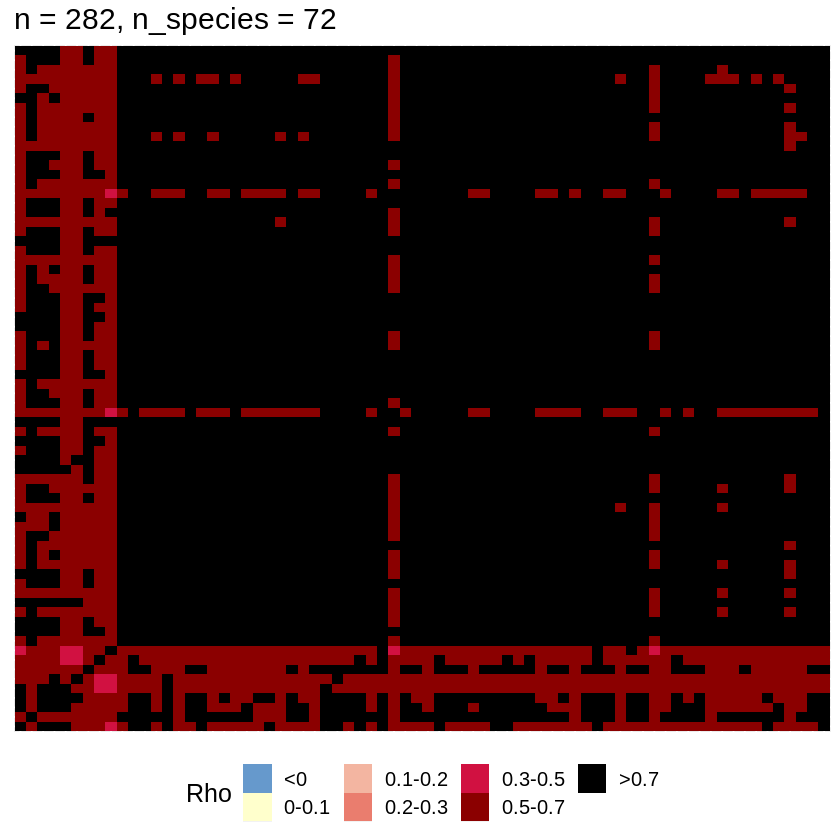

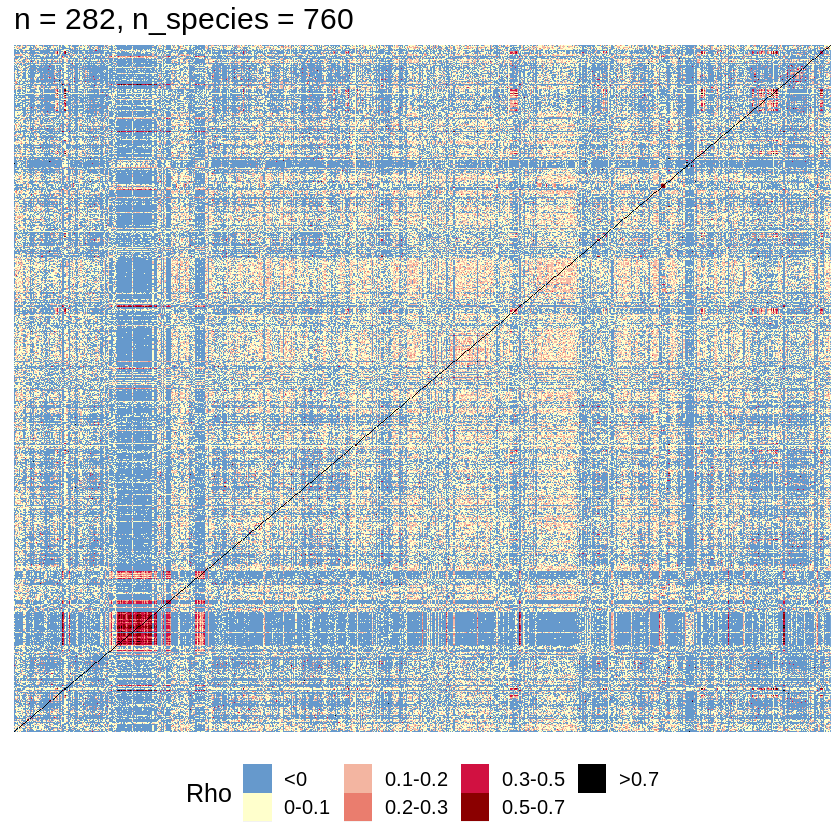

In [14]:
plot_iter <- list(c("site_supplying_sample", "HELIOS"), 
                  c("extraction_kit", "abGENIX Whole Blood Genomic DNA Extraction Kit"),
                  c("hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot", "20392972"),
                  c("hiseq_xtm_flow_cell_v2_5_lot", "20367079"))
item <- plot_iter[[4]]

var_name <- item[1]
level_name <- item[2]
mec_contam <- corr_res %>% 
    filter(level == level_name) %>%
    filter(rho > 0.7)
mec_contam <- c(mec_contam$contaminant_taxon, mec_contam$non_contaminant_taxon)

mec_nc <- corr_res %>% 
    filter(level == level_name) %>%
    filter(rho <= 0.7)
mec_nc <- mec_nc$non_contaminant_taxon

contam_df <- df_filt %>% 
    left_join(meta_filt) %>%
    filter(get(var_name) == level_name) %>%
    select(all_of(mec_contam))
nc_df <- df_filt %>% 
    left_join(meta_filt) %>%
    filter(get(var_name) == level_name) %>%
    select(all_of(mec_nc))

plot_heatmap(contam_df)
ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_contaminants.{var_name}.{level_name}.pdf"), 
       dpi = 600, 
       height = 9, width = 7.5)
plot_heatmap(nc_df)
    ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_non_contaminants.{var_name}.{level_name}.png"), 
       dpi = 600, 
       height = 9, width = 7.5)


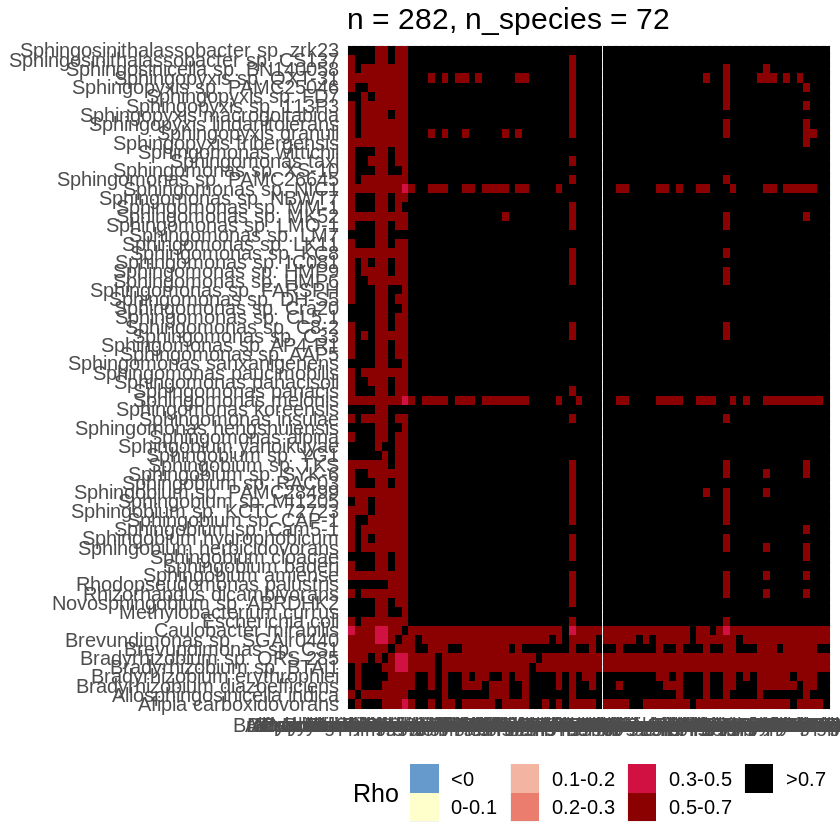

In [13]:
dat <- contam_df
plot_df <- as.data.frame(cor(dat)) %>%
        rownames_to_column("taxa1") %>%
        pivot_longer(!taxa1, names_to = "taxa2", values_to = "rho") %>%
                mutate(fill_color = case_when(rho <= 0 ~ "<0",
                         rho > 0 & rho <= 0.1 ~ "0-0.1",
                         rho > 0.1 & rho <= 0.2 ~ "0.1-0.2",
                         rho > 0.2 & rho <= 0.3 ~ "0.2-0.3",
                         rho > 0.3 & rho <= 0.5 ~  "0.3-0.5",
                         rho > 0.5 & rho <= 0.7 ~ "0.5-0.7",
                         rho > 0.7 ~ ">0.7")) %>%
        mutate(fill_color = factor(fill_color, levels = c("<0", "0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.5", "0.5-0.7", ">0.7")))

plot_df %>% fwrite("results/figure_source_data_nat_micro/correlation_contaminants.csv")

plot_df %>%
        ggplot(aes(x = taxa1, y = taxa2, fill = fill_color)) + 
        geom_tile() +
        scale_fill_manual(values = c("#6699cc", "#ffffcc", "#f39b7fb2", "#e64b35b2", "#d11141", "darkred", "black"), drop = F) +
        theme(text = element_text(size = 15),
              legend.position = "bottom",
              axis.title = element_blank(),
              axis.ticks = element_blank()) +
    labs(fill = "Rho", title = str_glue("n = {nrow(dat)}, n_species = {ncol(dat)}"))

# ggsave(str_glue("results/decontamination/correlation_decontamination/correlation_contaminants.axis_text.{var_name}.{level_name}.png"), 
#        dpi = 600, 
#        height = 9, width = 7.5)